# Testing PCA Class

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PCA import PCA
from scipy.interpolate import CubicSpline
from LeastSquares import LeastSquares
%matplotlib notebook 

In [25]:
freq = [0.01, 0.022, 0.045, 0.408, 1.42,2.326] #6 frequencies
freq_arr = (np.array(freq)).reshape(len(freq),1) #creating freq array (6x1)
freq_mis = [freq[3],freq[4]] #frequencies for missing data
freq_four = [0.045, 0.408, 1.42, 2.326]
freq_four2 = [0.010, 0.022, 0.408, 1.42]
freq_10 = np.linspace(0.1, 1.8, 10) #ten freq

pca = PCA(freq) #object of PCA class
pca_mis = PCA(freq_mis) #object of PCA class for 2 freq
pca_four = PCA(freq_four) #object for 4 freq
pca_four2 = PCA(freq_four2)
pca_ten = PCA(freq_10) #obhect for 10 freq
ls = LeastSquares(freq_arr) #object of LeastSquares class

clean_matrix,clean_dict = pca.data_matrix('all_data.npz') #data matrix for clean data
noisy_matrix,noisy_dict = pca.data_matrix('noisy_data_2.npz') #data matrix for noisy data
blur_matrix,blur_dict = pca.data_matrix('blurry_data_new.npz') #data matrix for blurred data
noisblur_matrix,blur_noisy_dict = pca.data_matrix('blurry_noisy_data_2.npz') #data matrix for blurred noisy data

#data from different part of sky (more in galactic plane)
diff_matrix,diff_dict = pca.data_matrix('diff_data.npz') #data matrix from diff part of sky 
diffnoisy_matrix,diffnoisy_dict = pca.data_matrix('diff_noisy_data.npz') #noisy data
diffblur_matrix,diffblur_dict = pca.data_matrix('diff_blurry_data.npz') #blurred data 
diffblur_noisy_matrix,diffblur_noisy_dict = pca.data_matrix('diff_blurry_noisy_data.npz') #blurred noisy data

#data blurred systematically (lower frequencies blurred more than higher frequencies)
sysblur_matrix,sysblur_dict = pca.data_matrix('diff_blurry_data_2.npz') #blurred data 
sysblur_noisy_matrix,sysblur_noisy_dict = pca.data_matrix('diff_blurry_noisy_data_2.npz') #blurred noisy data

#data with missing freq (only 2 freq)
mis_matrix, missing_dict = pca_mis.data_matrix('data_at_2_frqs.npz')
mis_matrix2, missing_dict2 = pca_mis.data_matrix('data_at_2_frqs_2.npz')
mis_matrix2 = mis_matrix2.T

#data with missing freq (4 freq)
four_matrix,four_dict = pca_four.data_matrix('data_4_freqs.npz')
four_matrix2,four_dict2 = pca_four2.data_matrix('data_4_freqs_2.npz')

#data with 10 freq
ten_matrix,ten_dict = pca_ten.data_matrix('data_10_freqs.npz')

#finding rms of frequencies and normalized matrices
rms_freq, nor_clean_matrix = pca.normalized_rms(clean_matrix)
rms_freq_diff, nor_diff_matrix = pca.normalized_rms(diff_matrix)
rms_freq_diffblur,nor_diffblur_matrix = pca.normalized_rms(diffblur_matrix)
rms_freq_sysblur,nor_sysblur_matrix = pca.normalized_rms(sysblur_matrix)
rms_freq_noisy,nor_noisy_matrix = pca.normalized_rms(noisy_matrix)
rms_freq_noisblur,nor_noisblur_matrix = pca.normalized_rms(noisblur_matrix)
rms_freq_mis, nor_mis_matrix = pca_mis.normalized_rms(mis_matrix)
rms_freq_mis2, nor_mis_matrix2 = pca_mis.normalized_rms(mis_matrix2)
rms_freq_four,nor_four_matrix = pca_four.normalized_rms(four_matrix)
rms_freq_four2,nor_four_matrix2 = pca_four2.normalized_rms(four_matrix2)
rms_freq_ten, nor_ten_matrix = pca_ten.normalized_rms(ten_matrix)

## Dividing Spectra by Average (Power Law)

Using the <strong>LeastSquares</strong> class, I fitted the average of the spectra to a power law. Then, I divided the whole spectra by that power law to create a more flattened curve. The <strong>ymodel</strong> function for the power law returns the y model or <strong>pow_freq_fit</strong> in the form 

$$\bar{y} = \begin{bmatrix}
log(y_{1}) \\
log(y_{2}) \\
\vdots \\
\end{bmatrix}$$

Since it is the log of the y values, I took the exponential of that log (line 6) to get the actual y value. With that, I don't need to graph the new spectra on a log-log graph.

In [3]:
freq_pow = ls.pow_matrix() #data matrix for power law model
mean_y = np.mean(clean_matrix, axis = 0) #mean of clean spectra
log_mean_y = (np.log(mean_y)).reshape(mean_y.shape[0],1) #log of mean and reshaping (6x1)

pow_freq_fit, pow_freq_param, pow_error = ls.ymodel(freq_pow, log_mean_y) #fit for model (y values), parameters, error
fit_y = np.exp(pow_freq_fit) #taking exponential of pow_freq_fit to get y value

In [4]:
num_rows = clean_matrix.shape[0] #number of rows of clean matrix
num_col = clean_matrix.shape[1] #number of columns of clean matrix
avg_clean_matrix = np.zeros((num_rows,num_col)) #creating empty array to store values

for i in np.arange(num_rows):
    #dividing each row of clean matrix by average data 
    avg_clean_matrix[i] = np.divide(clean_matrix[i].reshape(1,num_col),fit_y.reshape(1,num_col)) #storing it in avg_clean_matrix
    
avg_clean_dict = dict(zip(freq,(avg_clean_matrix[:,i] for i in range(avg_clean_matrix.shape[0])))) 

## Determining Eigenvalues and Eigenvectors

In [32]:
#finding covariances
cov,stand_matrix = pca.cov_matrix(nor_clean_matrix) #clean data
noisy_cov,noisy_stand_matrix = pca.cov_matrix(nor_noisy_matrix) #noisy data
blur_noisy_cov,blur_noisy_stand = pca.cov_matrix(nor_noisblur_matrix) #blurred noisy data
diff_cov, diff_stand_matrix = pca.cov_matrix(nor_diff_matrix) #galactic plane
diffblur_cov, diffblur_stand_matrix = pca.cov_matrix(nor_diffblur_matrix) #galactic plane blurred
sysblur_cov, sysblur_stand_matrix = pca.cov_matrix(nor_sysblur_matrix) #blurred systematically
avg_cov,s = pca.cov_matrix(avg_clean_matrix) #spectra divided by the average
mis_cov,mis_stand_matrix = pca_mis.cov_matrix(nor_mis_matrix) #2 freq 
mis_cov2,mis_stand_matrix2 = pca_mis.cov_matrix(nor_mis_matrix2) #2 freq
four_cov,four_stand_matrix = pca_four.cov_matrix(nor_four_matrix) #4 freq
four_cov2,four_stand_matrix2 = pca_four2.cov_matrix(nor_four_matrix2) #4 freq
ten_cov, ten_stand_matrix = pca_ten.cov_matrix(nor_ten_matrix) #10 freq
#finding correlation matrix
corr = pca.corr_matrix(nor_clean_matrix) #clean data
corr_noisy = pca.corr_matrix(nor_noisy_matrix) #noisy
corr_blurnoisy = pca.corr_matrix(nor_noisblur_matrix) #noisy blurred
corr_diff = pca.corr_matrix(nor_diff_matrix) #galactic plane
corr_diffblur = pca.corr_matrix(nor_diffblur_matrix) #blurred galactic
corr_sysblur = pca.corr_matrix(nor_sysblur_matrix) #systematically blurred
corr_miss = pca_mis.corr_matrix(nor_mis_matrix) #2 freq
corr_miss2 = pca_mis.corr_matrix(nor_mis_matrix2) #2 freq
corr_four = pca_four.corr_matrix(nor_four_matrix) #4 freq
corr_four2 = pca_four2.corr_matrix(nor_four_matrix2) #4 freq
corr_ten = pca_ten.corr_matrix(nor_ten_matrix) #10 freq

#finding eigenvalues and eigenvectors
eigval,eigvec,eigpairs = pca.eig_values(cov) #clean matrix
eigval_dict = pca.ordered_eigval(eigval)
corr_eigval,corr_eigvec,corr_eigpairs = pca.eig_values(corr) #correlation for clean data
corr_eigval_dict = pca.ordered_eigval(corr_eigval)

noisy_eigval,noisy_eigvec,noisy_eigpairs = pca.eig_values(noisy_cov) #noisy data
noisblur_eigval,noisblur_eigvec,noisblur_eigpairs = pca.eig_values(blur_noisy_cov) #noisy blurred 
noisy_eigval_dict = pca.ordered_eigval(noisy_eigval)
noisycorr_eigval,noisycorr_eigvec,noisycorr_eigpairs = pca.eig_values(corr_noisy) #noisy corr
noisblurcorr_eigval,noisblurcorr_eigvec,noisblurcorr_eigpairs = pca.eig_values(corr_blurnoisy) #noisy blurred corr
noisblur_eigval_dict = pca.ordered_eigval(noisblur_eigval)
noisblurcorr_eigval_dict = pca.ordered_eigval(noisblurcorr_eigval)

divavg_eigval,divavg_eigvec,divavg_eigpairs = pca.eig_values(avg_cov) #data divided by average
divavg_eigval_dict = pca.ordered_eigval(divavg_eigval)

diff_eigval,diff_eigvec,diff_eigpairs = pca.eig_values(diff_cov) #data more in galactic plane
diff_eigval_dict = pca.ordered_eigval(diff_eigval)
diffcorr_eigval,diffcorr_eigvec,diffcorr_eigpairs = pca.eig_values(corr_diff) #correlation matrix

diffblur_eigval,diffblur_eigvec,diffblur_eigpairs = pca.eig_values(diffblur_cov) #blurred data in galactic plane
diffblur_eigval_dict = pca.ordered_eigval(diffblur_eigval)
diffblurcorr_eigval,diffblurcorr_eigvec,diffblurcorr_eigpairs = pca.eig_values(corr_diffblur) #correlation amtrix

sysblur_eigval,sysblur_eigvec,sysblur_eigpairs = pca.eig_values(sysblur_cov) #systematically blurred in galactic plane
sysblur_eigval_dict = pca.ordered_eigval(sysblur_eigval)
sysblurcorr_eigval,sysblurcorr_eigvec,sysblurcorr_eigpairs = pca.eig_values(corr_sysblur) #correlation amtrix

mis_eigval,mis_eigvec,mis_eigpairs = pca_mis.eig_values(mis_cov) #2 freq
mis_eigval2,mis_eigvec2,mis_eigpairs2 = pca_mis.eig_values(mis_cov2) #2 freq
mis_eigdict = pca_mis.ordered_eigval(mis_eigval)
mis_eigdict2 = pca_mis.ordered_eigval(mis_eigval2)
miscorr_eigval,miscorr_eigvec,miscorr_eigpairs = pca_mis.eig_values(corr_miss) #corr matrix for 2 freq
miscorr_eigval2,miscorr_eigvec2,miscorr_eigpairs2 = pca_mis.eig_values(corr_miss2)  #corr matrix for 2 freq

four_eigval,four_eigvec,four_eigpairs = pca_four.eig_values(four_cov) #4 freq
four_eigval2,four_eigvec2,four_eigpairs2 = pca_four2.eig_values(four_cov2) #4 freq
four_eigdict = pca_four.ordered_eigval(four_eigval)
four_eigdict2 = pca_four2.ordered_eigval(four_eigval2)
fourcorr_eigval,fourcorr_eigvec,fourcorr_eigpairs = pca_four.eig_values(corr_four) #corr for 4 freq
fourcorr_eigval2,fourcorr_eigvec2,fourcorr_eigpairs2 = pca_four2.eig_values(corr_four2) #corr for 4 freq

ten_eigval,ten_eigvec,ten_eigpairs = pca_ten.eig_values(ten_cov) #10 freq
tencorr_eigval,tencorr_eigvec,tencorr_eigpairs = pca_ten.eig_values(corr_ten) #corr for 10 freq
ten_eigdict = pca_ten.ordered_eigval(ten_eigval)
tencorr_eigdict = pca_ten.ordered_eigval(tencorr_eigval)

## Plotting Eigenvalues and Eigenvectors

<IPython.core.display.Javascript object>


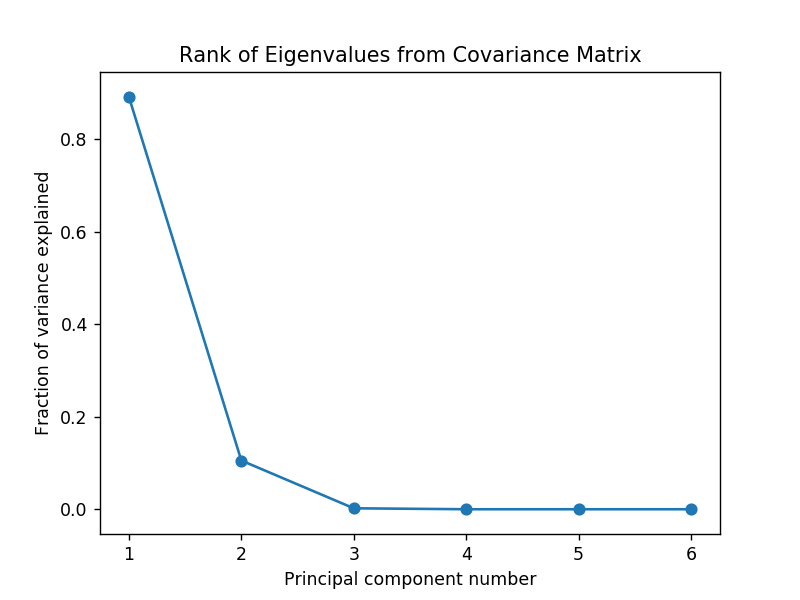

<IPython.core.display.Javascript object>


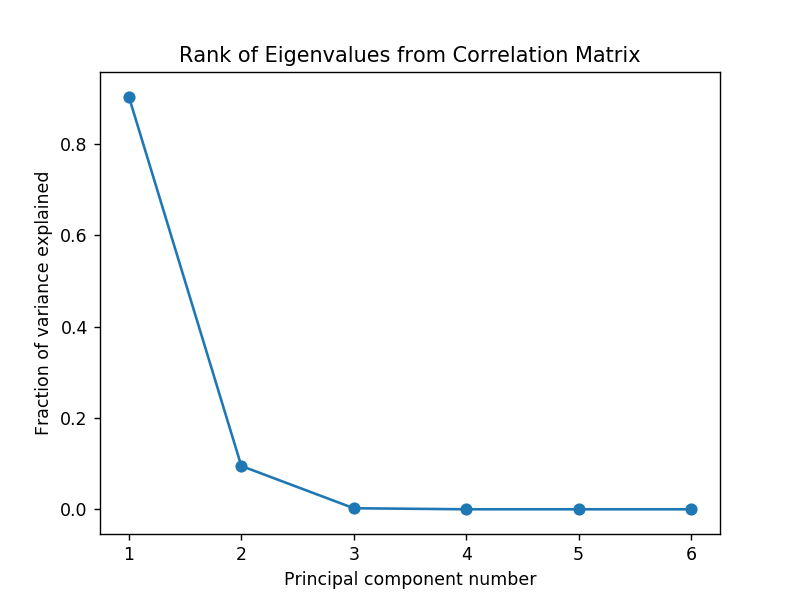

<IPython.core.display.Javascript object>


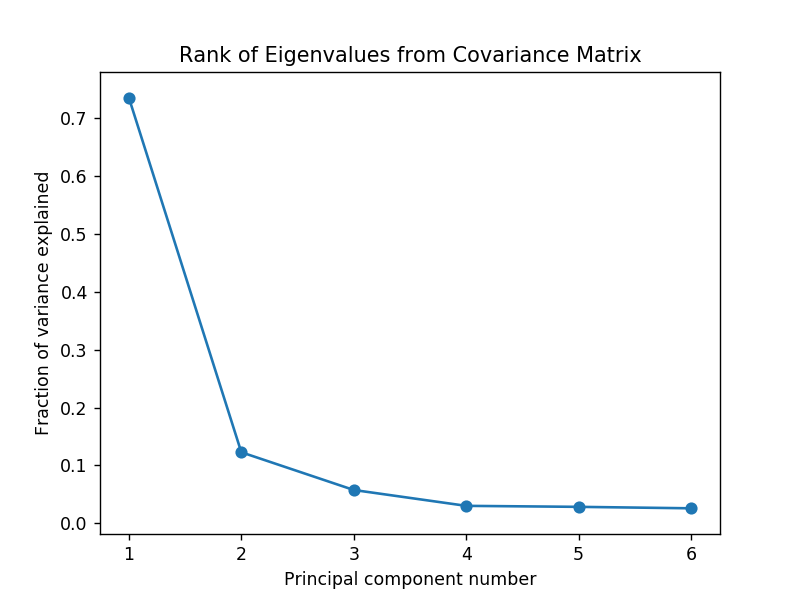

<IPython.core.display.Javascript object>


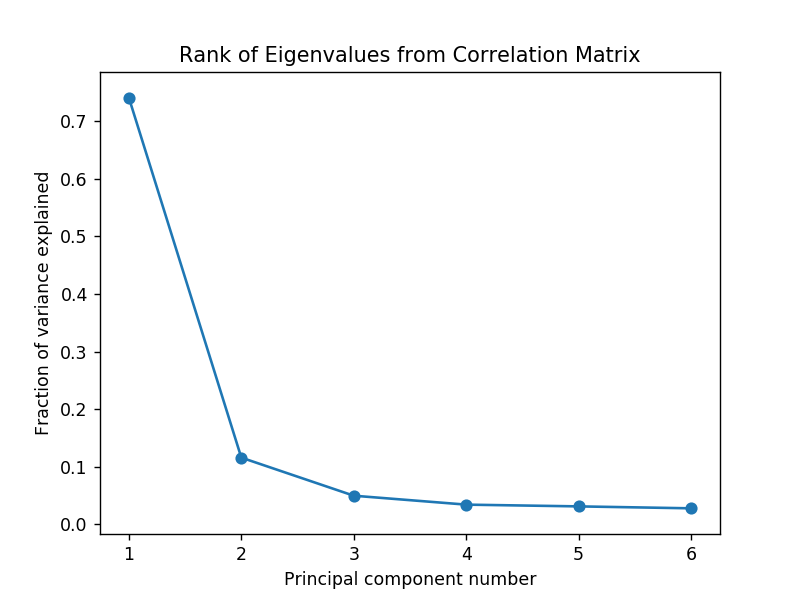

<IPython.core.display.Javascript object>


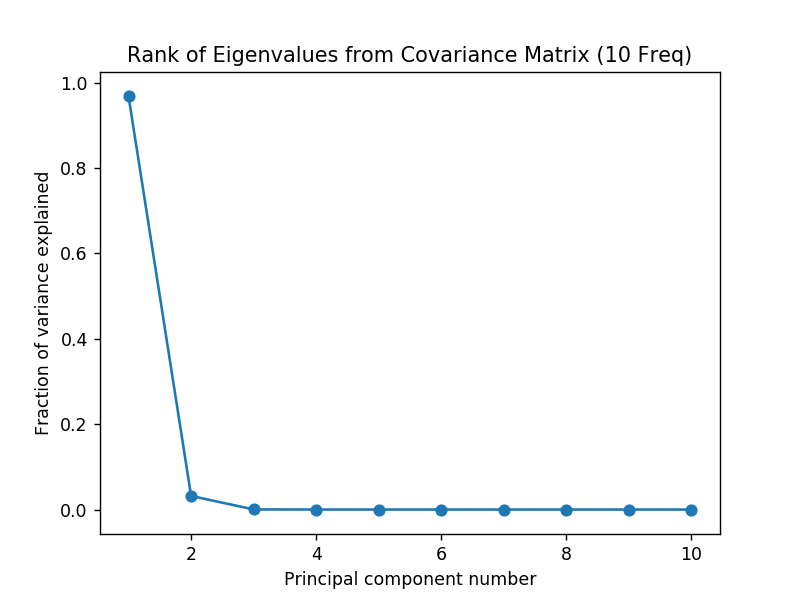

<IPython.core.display.Javascript object>


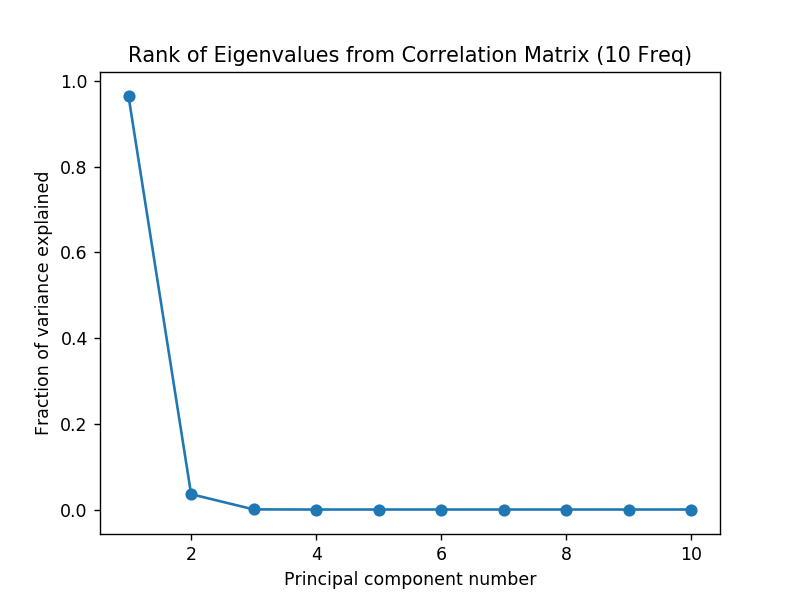

In [34]:
pca.graph_eigval('Rank of Eigenvalues from Covariance Matrix',eigval_dict)
# plt.savefig('cov_eig')
pca.graph_eigval('Rank of Eigenvalues from Correlation Matrix',corr_eigval_dict)
# plt.savefig('corr_eig')
pca.graph_eigval('Rank of Eigenvalues from Covariance Matrix',noisblur_eigval_dict)
pca.graph_eigval('Rank of Eigenvalues from Correlation Matrix',noisblurcorr_eigval_dict)
pca.graph_eigval('Rank of Eigenvalues from Covariance Matrix (10 Freq)',ten_eigdict)
pca.graph_eigval('Rank of Eigenvalues from Correlation Matrix (10 Freq)',tencorr_eigdict)
# pca.graph_eigval('Rank of Eigenvalues for Covariance Matrix from Different Part of Sky',diff_eigval_dict)
# pca.graph_eigval('Rank of Eigenvalues for Covariance Matrix (Diff Blurred)',diffblur_eigval_dict)
# pca.graph_eigval('Rank of Eigenvalues for Cov Matrix (Diff Blurred Systematically)',sysblur_eigval_dict)
# pca_mis.graph_eigval('Rank of Eigenvalues for Missing Data 1',mis_eigdict)
# pca_mis.graph_eigval('Rank of Eigenvalues for Missing Data 2',mis_eigdict2)
# pca_four.graph_eigval('Rank of Eigenvalues for Data with Four Freq',four_eigdict)
# pca_four2.graph_eigval('Rank of Eigenvalues for Data with Four Freq 2',four_eigdict2)
# pca.graph_eigval('Rank of Eigenvalues for Noisy Covariance Matrix',noisy_eigval_dict)

In [7]:
# plt.figure()
# plt.title('Eigenvectors for Covariance Matrix')
# legend_arr = []
# for i in np.arange(eigvec.shape[1]):
#     plt.plot(eigvec[:,i])
#     legend_arr.append('Eigvec '+ str(i+1))
# #     plt.quiver([0,0],*eigvec[:,i],scale=1.15,color='b')
# plt.legend(legend_arr,loc='lower left')
# plt.show()

# plt.figure()
# plt.title('Eigenvectors for Correlation Matrix')
# for i in np.arange(corr_eigvec.shape[1]):
#     plt.plot(corr_eigvec[:,i])
# #     plt.quiver([0,0],*eigvec2[:,i],scale=1.15,color='orange')
# plt.show()

## Testing Principal Component Fits

We can write the spectra as a linear combination of the eigenvectors so that
$$\vec{s} = a_{1}\vec{v_{1}} + a_{2}\vec{v_{3}} + a_{3}\vec{v_{3}} +\ldots= \sum_{i}^{p}{a_{i}\vec{v_{i}}} $$
where $ \{a_{1},a_{2},\ldots\} $ is the expansion coefficient. Through this, we form a different basis with the eigenvectors. 

Now, how do we find the coefficients? We can rewrite this in matrix form where the spectra $S$ is a $nxp$ matrix so that
$$S = \begin{bmatrix}
    a_{1} \\
    a_{2} \\
    \vdots \\
    a_{n} \\
    \end{bmatrix} * [\vec{v_{1}} \vec{v_{2}} \ldots \vec{v_{p}}]$$
    
This looks similar to a least squares problem where we are trying to find the parameters, or, in this case, the coefficients for the eigenvectors. Using this reasoning, I used the <strong>ymodel</strong> function from the <strong>LeastSquares</strong> class which returns the values for the fit, parameters, and the error covariance. Since the <strong>ymodel</strong> function already returns the new fit based on the principal components, I didn't need to recalculate it using the coefficients and eigenvectors.

In [23]:
total_fit,total_coef,total_err = ls.ymodel(eigvec,nor_clean_matrix.T) #fit for all principal components (pc)
one_fit,one_coef,one_err = ls.ymodel(eigvec[:,0].reshape(eigvec.shape[0],1),nor_clean_matrix.T) #one pc
two_fit,two_coef,two_err = ls.ymodel(eigvec[:,:2].reshape(eigvec.shape[0],2),nor_clean_matrix.T) #two pc
three_coef = ls.coef(eigvec[:,:3].reshape(eigvec.shape[0],3),nor_clean_matrix.T) #three pc
four_coef = ls.coef(eigvec[:,:4].reshape(eigvec.shape[0],4),nor_clean_matrix.T) #four pc
corr_one_coef = ls.coef(corr_eigvec[:,0].reshape(corr_eigvec.shape[0],1),nor_clean_matrix.T) #one pc
corr_two_coef = ls.coef(corr_eigvec[:,:2].reshape(corr_eigvec.shape[0],2),nor_clean_matrix.T) #two pc
#noisy data
noisy_onecoef = ls.coef(noisy_eigvec[:,0].reshape(noisy_eigvec.shape[0],1),nor_noisy_matrix.T)
noisy_twocoef = ls.coef(noisy_eigvec[:,:2].reshape(noisy_eigvec.shape[0],2),nor_noisy_matrix.T)
noisycorr_onecoef = ls.coef(noisycorr_eigvec[:,0].reshape(noisycorr_eigvec.shape[0],1),nor_noisy_matrix.T)
#noisy blurred data
noisblur_onecoef= ls.coef(noisblur_eigvec[:,0].reshape(noisblur_eigvec.shape[0],1),nor_noisblur_matrix.T)
noisblur_twocoef= ls.coef(noisblur_eigvec[:,:2].reshape(noisblur_eigvec.shape[0],2),nor_noisblur_matrix.T)
noisblurcorr_onecoef = ls.coef(noisblurcorr_eigvec[:,0].reshape(noisblurcorr_eigvec.shape[0],1),nor_noisblur_matrix.T)
#different data (from diff part of sky)
diff_total_coef = ls.coef(diff_eigvec,nor_diff_matrix.T) 
diff_one_coef= ls.coef(diff_eigvec[:,0].reshape(diff_eigvec.shape[0],1),nor_diff_matrix.T) 
diff_two_coef = ls.coef(diff_eigvec[:,:2].reshape(diff_eigvec.shape[0],2),nor_diff_matrix.T) 
diffcorr_one_coef = ls.coef(diffcorr_eigvec[:,0].reshape(diffcorr_eigvec.shape[0],1),nor_diff_matrix.T)

#different blurred data (from diff part of sky)
diff_total_coef2 = ls.coef(diffblur_eigvec,nor_diffblur_matrix.T) 
diffblur_one_coef = ls.coef(diffblur_eigvec[:,0].reshape(diffblur_eigvec.shape[0],1),nor_diffblur_matrix.T)  
diffblur_two_coef= ls.coef(diffblur_eigvec[:,:2].reshape(diffblur_eigvec.shape[0],2),nor_diffblur_matrix.T)
diffblurcorr_one_coef = ls.coef(diffblurcorr_eigvec[:,0].reshape(diffblurcorr_eigvec.shape[0],1),nor_diffblur_matrix.T)  

#different data blurred systematically (from diff part of sky)
sysblur_total_coef= ls.coef(sysblur_eigvec,nor_sysblur_matrix.T) 
sysblur_one_coef = ls.coef(sysblur_eigvec[:,0].reshape(sysblur_eigvec.shape[0],1),nor_sysblur_matrix.T) 
sysblur_two_coef = ls.coef(sysblur_eigvec[:,:2].reshape(sysblur_eigvec.shape[0],2),nor_sysblur_matrix.T) 
sysblurcorr_one_coef = ls.coef(sysblurcorr_eigvec[:,0].reshape(sysblurcorr_eigvec.shape[0],1),nor_sysblur_matrix.T)  

#data with 2 freq
mis_total_coef = ls.coef(mis_eigvec,nor_mis_matrix.T) 
mis_one_coef = ls.coef(mis_eigvec[:,0].reshape(mis_eigvec.shape[0],1),nor_mis_matrix.T) 
mis_two_coef= ls.coef(mis_eigvec[:,:2].reshape(mis_eigvec.shape[0],2),nor_mis_matrix.T) 
mis_total_coef2 = ls.coef(mis_eigvec2,nor_mis_matrix2.T) 
mis_one_coef2 = ls.coef(mis_eigvec2[:,0].reshape(mis_eigvec2.shape[0],1),nor_mis_matrix2.T) 
mis_two_coef2 = ls.coef(mis_eigvec2[:,:2].reshape(mis_eigvec2.shape[0],2),nor_mis_matrix2.T)

miscorr_one_coef = ls.coef(miscorr_eigvec[:,0].reshape(miscorr_eigvec.shape[0],1),nor_mis_matrix.T) 
miscorr_two_coef = ls.coef(miscorr_eigvec[:,:2].reshape(miscorr_eigvec.shape[0],2),nor_mis_matrix.T) 
miscorr_one_coef2= ls.coef(miscorr_eigvec2[:,0].reshape(miscorr_eigvec2.shape[0],1),nor_mis_matrix2.T) 
miscorr_two_coef2 = ls.coef(miscorr_eigvec2[:,:2].reshape(miscorr_eigvec2.shape[0],2),nor_mis_matrix2.T) 

#data with 4 freq
four_one_coef = ls.coef(four_eigvec[:,0].reshape(four_eigvec.shape[0],1),nor_four_matrix.T) 
four_two_coef = ls.coef(four_eigvec[:,:2].reshape(four_eigvec.shape[0],2),nor_four_matrix.T)
fourcorr_one_coef = ls.coef(fourcorr_eigvec[:,0].reshape(fourcorr_eigvec.shape[0],1),nor_four_matrix.T) 
fourcorr_two_coef = ls.coef(fourcorr_eigvec[:,:2].reshape(fourcorr_eigvec.shape[0],2),nor_four_matrix.T) 

four_one_coef2 = ls.coef(four_eigvec2[:,0].reshape(four_eigvec2.shape[0],1),nor_four_matrix2.T) 
four_two_coef2 = ls.coef(four_eigvec2[:,:2].reshape(four_eigvec2.shape[0],2),nor_four_matrix2.T)
fourcorr_one_coef2 = ls.coef(fourcorr_eigvec2[:,0].reshape(fourcorr_eigvec2.shape[0],1),nor_four_matrix2.T) 
fourcorr_two_coef2= ls.coef(fourcorr_eigvec2[:,:2].reshape(fourcorr_eigvec2.shape[0],2),nor_four_matrix2.T) 

#data with 10 freq
ten_one_coef = ls.coef(ten_eigvec[:,0].reshape(ten_eigvec.shape[0],1),nor_ten_matrix.T) 
ten_two_coef = ls.coef(ten_eigvec[:,:2].reshape(ten_eigvec.shape[0],2),nor_ten_matrix.T)
tencorr_one_coef = ls.coef(tencorr_eigvec[:,0].reshape(tencorr_eigvec.shape[0],1),nor_ten_matrix.T) 
tencorr_two_coef = ls.coef(tencorr_eigvec[:,:2].reshape(tencorr_eigvec.shape[0],2),nor_ten_matrix.T) 

In the graphs, I plotted the fit for the principal components using different amounts of the principal componenets: all of the principal components, the first principal component, and the first two prinicpal components. 

In [9]:
pixel = 140000
# plt.figure()
# plt.plot(np.log(freq),one_fit[:,pixel])
# plt.plot(np.log(freq),two_fit[:,pixel])
# plt.scatter(np.log(freq),clean_matrix[pixel])
# plt.plot(freq,clean_matrix[pixel],'o',freq,total_fit[:,pixel],'-',freq,one_fit[:,pixel],'-',freq,two_fit[:,pixel],'-')
# plt.legend(['data','All PC','One PC','Two PC'],loc='upper right')
# plt.yscale('log')
# plt.xlabel('Frequency (GHz)')
# plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
# plt.title('Comparing Principal Component Fits')

pixel2 = 50000
# #graphs for data from different part of sky
# plt.figure()
# plt.plot(freq,diff_matrix[pixel2],'o',freq,diff_total_fit[:,pixel2],'-',freq,diff_one_fit[:,pixel2],'-',freq,diff_two_fit[:,pixel2],'-')
# plt.legend(['data','All PC','One PC','Two PC'],loc='upper right')
# plt.yscale('log')
# plt.xlabel('Frequency (GHz)')
# plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
# plt.title('Comparing Principal Component Fits for Different Part of Sky')

# plt.figure()
# plt.plot(freq,diffblur_matrix[pixel2],'o',freq,diffblur_total_fit[:,pixel2],'-', freq,diffblur_one_fit[:,pixel2],'-',freq,diffblur_two_fit[:,pixel2],'-')
# plt.legend(['data','All PC','One PC','Two PC'],loc='upper right')
# plt.yscale('log')
# plt.xlabel('Frequency (GHz)')
# plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
# plt.title('Comparing Principal Component Fits (Smooth)')

# plt.figure()
# plt.plot(freq,diffblur_matrix2[pixel2],'o',freq,diffblur_total_fit2[:,pixel2],'-',freq,diffblur_one_fit2[:,pixel2],'-',freq,diffblur_two_fit2[:,pixel2],'-')
# plt.yscale('log')
# plt.legend(['data','All PC','One PC','Two PC'],loc='upper right')
# plt.xlabel('Frequency (GHz)')
# plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
# plt.title('Comparing Principal Component Fits (Systematically Smooth)')

# plt.figure()
# plt.plot(freq,blur_noisy_matrix[pixel],'o',freq,
#          blur_noisy_totfit[:,pixel],'-',freq,blur_noisy_onefit[:,pixel],'-',freq,blur_noisy_twofit[:,pixel],'-')
# plt.yscale('log')
# plt.legend(['data','All PC','One PC','Two PC'],loc='upper right')
# plt.xlabel('Frequency (GHz)')
# plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
# plt.title('Comparing Principal Component Fits (Systematically Smooth and Noisy)')

## Cubic Spline Interpolation

Interpolation is the estimation of a value within a set of data points. The estimated curve passes through all the given points. Spline interpolation is a type of interpolation where the interpolant is a piecewise polynomial known as the spline. The cubic spline is the smoothest while also being the lowest degree. It also avoids the Runge's phenomenon where when interpolating with higher degrees can result in unexpected oscillations. 

Summary of steps for cubic spline interpolation for PCA:
<ol>
<li>Normalize data
    <ul>
    <li>Find rms: square each column of data (corresponding to each intensity values at that frequency), average those results, then take square root. The result is one rms value per frequency </li>
        <li>Take data and divide it by corresponding rms value at every frequency</li> </ul></li>
<li>Use normalized data to find principal component fits</li>
<li>Interpolate rms values and eigenvectors with log frequency
   <ul> <li>Note: frequency values subtituted in interpolation function to be uniform in log</li></ul></li>
<li>Find fits by multiplying coefficients and interpolated eigenvectors</li>
<li>Undo normalization by multiplying with interpolated rms</li>
</ol>

In [10]:
xnew = np.linspace(0.01,2.326,100) #freq values to be interpolated from
xnew_uniform = np.geomspace(0.01,2.326,100) #making xnew uniform in log
xnew_uniform_log = np.log(xnew_uniform)
xnew_log = np.log(xnew) 
freq_log = np.log(freq) 

In [11]:
# newfit_lin = pca.cub_interfit(freq,eigvec[:,0],xnew_uniform,one_coef,CubicSpline(freq,rms_freq))
# newfit_noisy_lin = pca.cub_interfit(freq,noisy_eigvec[:,0],xnew_uniform,noisy_onecoef,CubicSpline(freq,rms_freq))
# newfit_noisy2_lin = pca.cub_interfit(freq,noisy_eigvec[:,:2],xnew_uniform,noisy_twocoef,CubicSpline(freq,rms_freq))
# newfit_noisblur_lin = pca.cub_interfit(freq,noisblur_eigvec[:,0],xnew_uniform,noisblur_onecoef,CubicSpline(freq,rms_freq))
# newfit_noisblur2_lin = pca.cub_interfit(freq,noisblur_eigvec[:,:2],xnew_uniform,noisblur_twocoef,CubicSpline(freq,rms_freq))

# newfit_diffblur_lin = pca.cub_interfit(freq,diffblur_eigvec[:,0],xnew_uniform,diffblur_one_coef,rms_inter_lin)
# newfit_sysblur_lin = pca.cub_interfit(freq,sysblur_eigvec[:,0],xnew_uniform,sysblur_one_coef,rms_inter_lin)
# newfit_diffcorr_lin = pca.cub_interfit(freq,diffcorr_eigvec[:,0],xnew_uniform,diffcorr_one_coef,rms_inter_lin)
# newfit_diffblurcorr_lin = pca.cub_interfit(freq,diffblurcorr_eigvec[:,0],xnew_uniform,diffblurcorr_one_coef,rms_inter_lin)
# newfit_sysblurcorr_lin = pca.cub_interfit(freq,sysblurcorr_eigvec[:,0],xnew_uniform,sysblurcorr_one_coef,rms_inter_lin)

Below, I am creating the new interpolated PCA fits. As I am plotting it on log frequency, I pass in freq_log and xnew_uniform_log in the paramaters as well as the eigenvector and interpolated rms. A new fit is generated depending on how many principal components I want to use, if I use the correlation matrix, or the type of data used (e.g. noisy, blurred, etc.).

In [26]:
#fits for clean data (all overlapping pixels)
newfit = pca.cub_interfit(freq_log,eigvec[:,0],xnew_uniform_log,one_coef,rms_freq) #1 pc
newfit2 = pca.cub_interfit(freq_log,eigvec[:,:2],xnew_uniform_log,two_coef,rms_freq) #2 pc 
newfit3 = pca.cub_interfit(freq_log,eigvec[:,:3],xnew_uniform_log,three_coef,rms_freq) #3 pc
newfit_corr = pca.cub_interfit(freq_log,corr_eigvec[:,0],xnew_uniform_log,corr_one_coef,rms_freq) #1 pc correlation
newfit_corr2 = pca.cub_interfit(freq_log,corr_eigvec[:,:2],xnew_uniform_log,corr_two_coef,rms_freq) #2 pc correlation
#fits for noisy data
newfit_noisy = pca.cub_interfit(freq_log,noisy_eigvec[:,0],xnew_uniform_log,noisy_onecoef,rms_freq_noisy) #1 pc
newfit_noisy2 = pca.cub_interfit(freq_log,noisy_eigvec[:,:2],xnew_uniform_log,noisy_twocoef,rms_freq_noisy) #2 pc
newfit_noisycorr = pca.cub_interfit(freq_log,noisycorr_eigvec[:,0],xnew_uniform_log,noisycorr_onecoef,rms_freq_noisy)#1pc corr
#noisy blurred data
newfit_noisblur = pca.cub_interfit(freq_log,noisblur_eigvec[:,0],xnew_uniform_log,noisblur_onecoef,rms_freq_noisblur) #1 pc
newfit_noisblur2 = pca.cub_interfit(freq_log,noisblur_eigvec[:,:2],xnew_uniform_log,noisblur_twocoef,rms_freq_noisblur) #2 pc
newfit_noisblurcorr = pca.cub_interfit(freq_log,noisblurcorr_eigvec[:,0],xnew_uniform_log,noisblurcorr_onecoef,rms_freq_noisblur)#1pc corr
#different part of sky (galactic plane)
newfit_diff = pca.cub_interfit(freq_log,diff_eigvec[:,0],xnew_uniform_log,diff_one_coef,rms_freq_diff) #1 pc
newfit_diff2 = pca.cub_interfit(freq_log,diff_eigvec[:,:2],xnew_uniform_log,diff_two_coef,rms_freq_diff) #2 pc
newfit_diffcorr = pca.cub_interfit(freq_log,diffcorr_eigvec[:,0],xnew_uniform_log,diffcorr_one_coef,rms_freq_diff) #correlation 1 pc
newfit_diffblur = pca.cub_interfit(freq_log,diffblur_eigvec[:,0],xnew_uniform_log,diffblur_one_coef,rms_freq_diffblur) #blurred 1 pc
newfit_diffblur2 = pca.cub_interfit(freq_log,diffblur_eigvec[:,:2],xnew_uniform_log,diffblur_two_coef,rms_freq_diffblur) #blurred 2 pc
newfit_diffblurcorr = pca.cub_interfit(freq_log,diffblurcorr_eigvec[:,0],xnew_uniform_log,diffblurcorr_one_coef,rms_freq_diffblur) #blurred corr 1 pc
newfit_sysblur = pca.cub_interfit(freq_log,sysblur_eigvec[:,0],xnew_uniform_log,sysblur_one_coef,rms_freq_sysblur) #1 pc sys blur
newfit_sysblur2 = pca.cub_interfit(freq_log,sysblur_eigvec[:,:2],xnew_uniform_log,sysblur_two_coef,rms_freq_sysblur) #2pc sys blur
newfit_sysblurcorr = pca.cub_interfit(freq_log,sysblurcorr_eigvec[:,0],xnew_uniform_log,sysblurcorr_one_coef,rms_freq_sysblur) #corr 1 pc sysblur
#data with 2 frequencies
newfit_mis = pca_mis.cub_interfit(np.log(freq_mis),mis_eigvec[:,0],xnew_uniform_log,mis_one_coef,rms_freq_mis) #1pc
newfit_mistwo = pca_mis.cub_interfit(np.log(freq_mis),mis_eigvec[:,:2],xnew_uniform_log,mis_two_coef,rms_freq_mis) #2pc 
newfit_miscorr = pca_mis.cub_interfit(np.log(freq_mis),miscorr_eigvec[:,0],xnew_uniform_log,miscorr_one_coef,rms_freq_mis)#corr 1pc
newfit_miscorrtwo = pca_mis.cub_interfit(np.log(freq_mis),miscorr_eigvec[:,:2],xnew_uniform_log,miscorr_two_coef,rms_freq_mis)#corr 2pc
#other data set w/only 2 freq
newfit_mis2 = pca_mis.cub_interfit(np.log(freq_mis),mis_eigvec2[:,0],xnew_uniform_log,mis_one_coef2,rms_freq_mis2)
newfit_mistwo2 = pca_mis.cub_interfit(np.log(freq_mis),mis_eigvec2[:,:2],xnew_uniform_log,mis_two_coef2,rms_freq_mis2)
newfit_miscorr2 = pca_mis.cub_interfit(np.log(freq_mis),miscorr_eigvec2[:,0],xnew_uniform_log,miscorr_one_coef2,rms_freq_mis2)
newfit_miscorrtwo2 = pca_mis.cub_interfit(np.log(freq_mis),miscorr_eigvec2[:,:2],xnew_uniform_log,miscorr_two_coef2,rms_freq_mis2)
#data with four freq
newfit_four = pca_four.cub_interfit(np.log(freq_four),four_eigvec[:,0],xnew_uniform_log,four_one_coef,rms_freq_four)
newfit_fourtwo = pca_four.cub_interfit(np.log(freq_four),four_eigvec[:,:2],xnew_uniform_log,four_two_coef,rms_freq_four)
newfit_fourcorr = pca_four.cub_interfit(np.log(freq_four),fourcorr_eigvec[:,0],xnew_uniform_log,fourcorr_one_coef,rms_freq_four)
newfit_fourcorrtwo = pca_four.cub_interfit(np.log(freq_four),fourcorr_eigvec[:,:2],xnew_uniform_log,fourcorr_two_coef,rms_freq_four)
#other data set w/4 freq
newfit_four2 = pca_four2.cub_interfit(np.log(freq_four2),four_eigvec2[:,0],xnew_uniform_log,four_one_coef2,rms_freq_four2)
newfit_fourtwo2 = pca_four2.cub_interfit(np.log(freq_four2),four_eigvec2[:,:2],xnew_uniform_log,four_two_coef2,rms_freq_four2)
newfit_fourcorr2 = pca_four2.cub_interfit(np.log(freq_four2),fourcorr_eigvec2[:,0],xnew_uniform_log,fourcorr_one_coef2,rms_freq_four2)
newfit_fourcorrtwo2 = pca_four2.cub_interfit(np.log(freq_four2),fourcorr_eigvec2[:,:2],xnew_uniform_log,fourcorr_two_coef2,rms_freq_four2)
#data w/10 freq
newfit_ten = pca_ten.cub_interfit(np.log(freq_10),ten_eigvec[:,0],xnew_uniform_log,ten_one_coef,rms_freq_ten) #1 pc
newfit_ten2 = pca_ten.cub_interfit(np.log(freq_10),ten_eigvec[:,:2],xnew_uniform_log,ten_two_coef,rms_freq_ten) #1 pc
newfit_tencorr = pca_ten.cub_interfit(np.log(freq_10),tencorr_eigvec[:,0],xnew_uniform_log,tencorr_one_coef,rms_freq_ten) #1pc corr
newfit_tencorr2 = pca_ten.cub_interfit(np.log(freq_10),tencorr_eigvec[:,:2],xnew_uniform_log,tencorr_two_coef,rms_freq_ten) #2pc corr

In [37]:
# np.savez('10freq_1pc',newfit_ten)
# np.savez('10freq_corr1pc',newfit_tencorr)
# np.savez('10freq_2pc',newfit_ten2)
# np.savez('10freq_corr2pc',newfit_tencorr2)

<IPython.core.display.Javascript object>


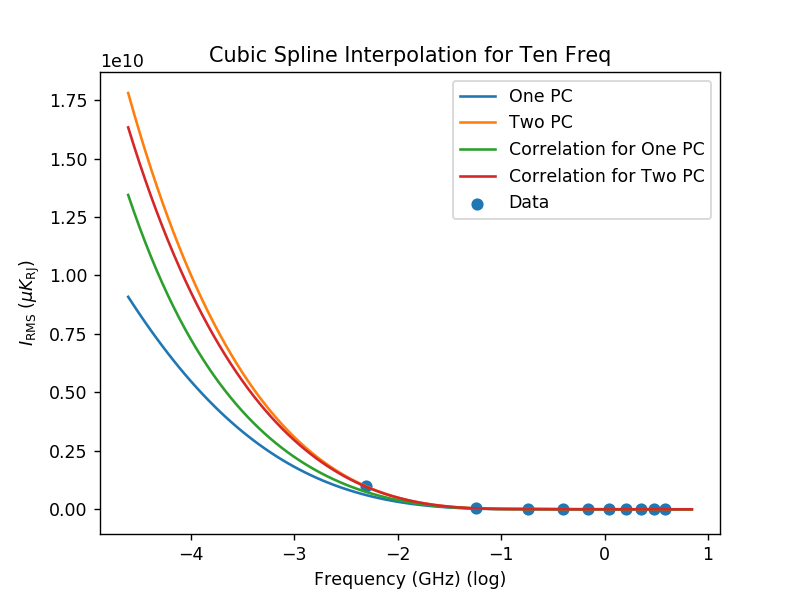

<IPython.core.display.Javascript object>


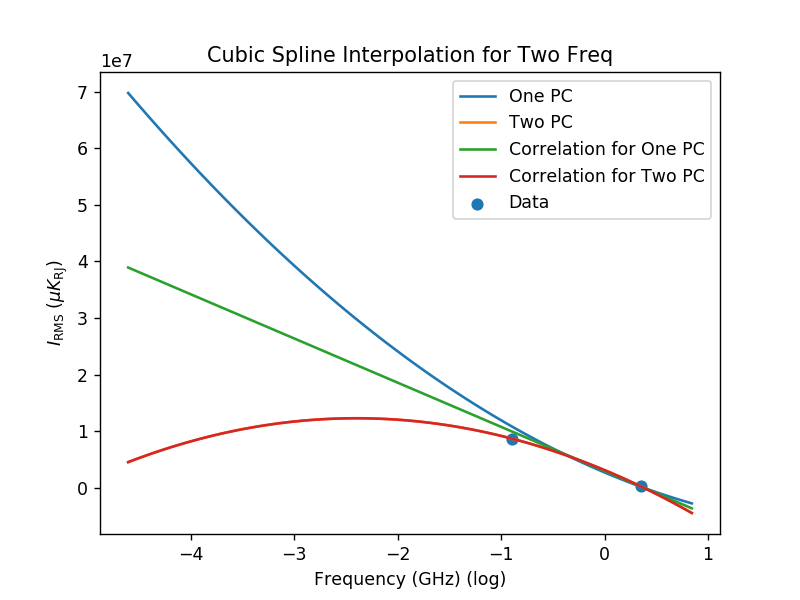

<IPython.core.display.Javascript object>


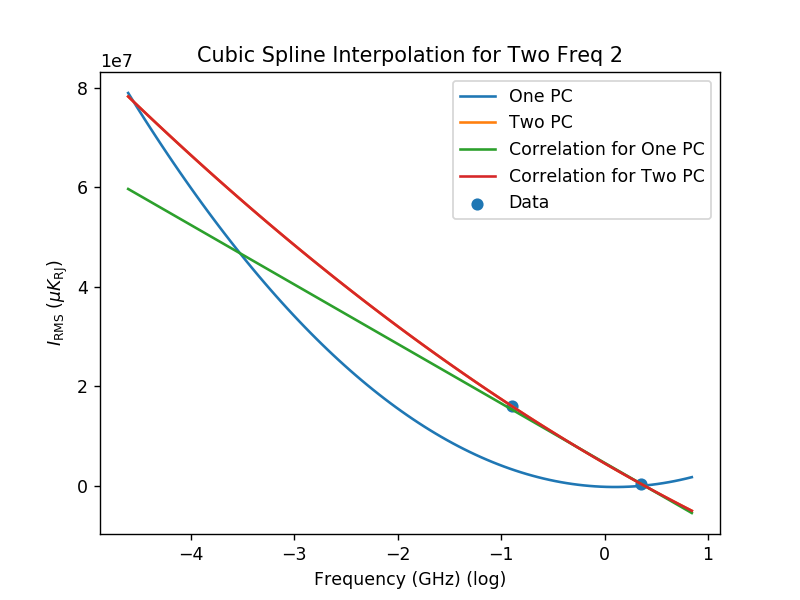

<IPython.core.display.Javascript object>


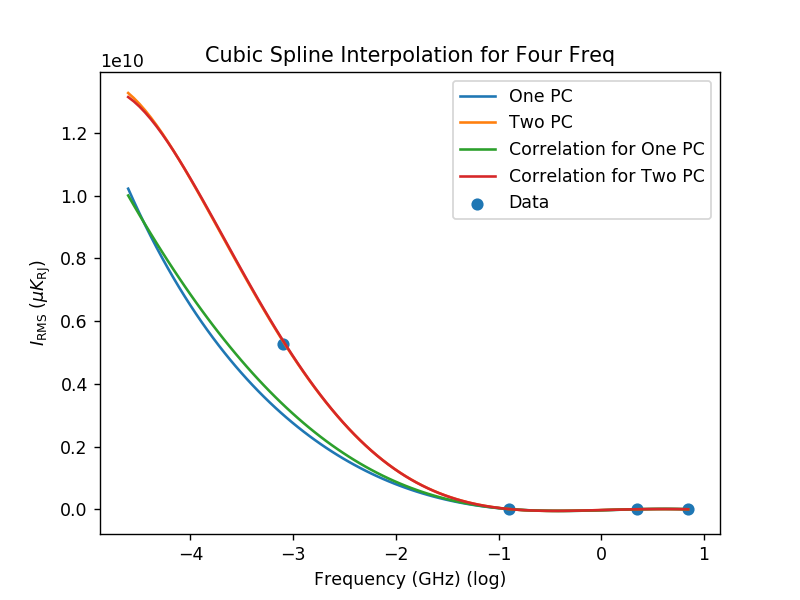

<IPython.core.display.Javascript object>


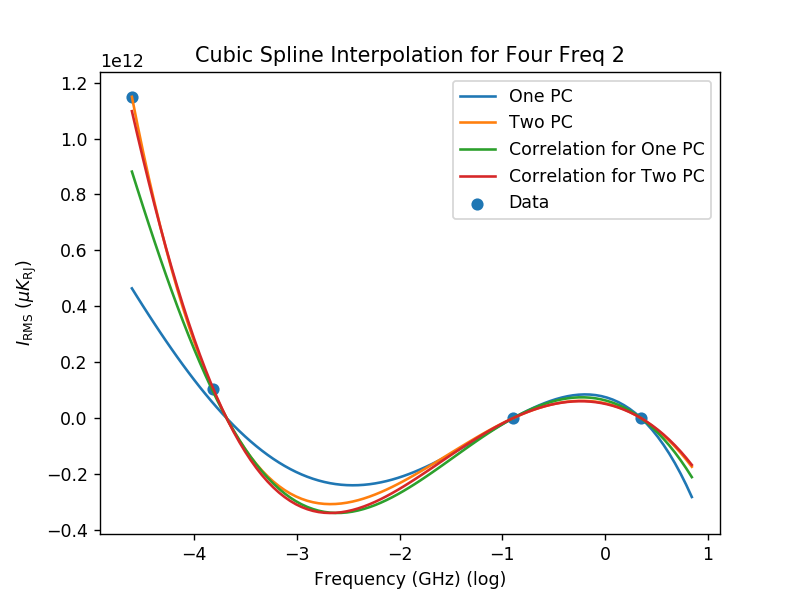

In [38]:
plt.figure()
plt.plot(xnew_uniform_log,newfit_ten[1000],label='One PC')
plt.plot(xnew_uniform_log,newfit_ten2[1000],label='Two PC')
plt.plot(xnew_uniform_log,newfit_tencorr[1000],label='Correlation for One PC')
plt.plot(xnew_uniform_log,newfit_tencorr2[1000],label='Correlation for Two PC')
plt.scatter(np.log(freq_10),ten_matrix[1000],label='Data')
plt.xlabel('Frequency (GHz) (log)')
plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
plt.title('Cubic Spline Interpolation for Ten Freq')
plt.legend(loc='upper right')
# plt.savefig('10freq')

plt.figure()
plt.plot(xnew_uniform_log,newfit_mis[1000],label='One PC')
plt.plot(xnew_uniform_log,newfit_mistwo[1000],label='Two PC')
plt.plot(xnew_uniform_log,newfit_miscorr[1000],label='Correlation for One PC')
plt.plot(xnew_uniform_log,newfit_miscorrtwo[1000],label='Correlation for Two PC')
plt.scatter(np.log(freq_mis),mis_matrix[1000],label='Data')
plt.xlabel('Frequency (GHz) (log)')
plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
plt.title('Cubic Spline Interpolation for Two Freq')
plt.legend(loc='upper right')
# plt.savefig('2freq')

plt.figure()
plt.plot(xnew_uniform_log,newfit_mis2[500],label='One PC')
plt.plot(xnew_uniform_log,newfit_mistwo2[500],label='Two PC')
plt.plot(xnew_uniform_log,newfit_miscorr2[500],label='Correlation for One PC')
plt.plot(xnew_uniform_log,newfit_miscorrtwo2[500],label='Correlation for Two PC')
plt.scatter(np.log(freq_mis),mis_matrix2[500],label='Data')
# plt.scatter(np.log(freq_mis),mis_eigvec2[:,0],label='Eigvec')
plt.xlabel('Frequency (GHz) (log)')
plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
plt.title('Cubic Spline Interpolation for Two Freq 2')
plt.legend(loc='upper right')
# plt.savefig('2freq_2')

plt.figure()
plt.plot(xnew_uniform_log,newfit_four[1000],label='One PC')
plt.plot(xnew_uniform_log,newfit_fourtwo[1000],label='Two PC')
plt.plot(xnew_uniform_log,newfit_fourcorr[1000],label='Correlation for One PC')
plt.plot(xnew_uniform_log,newfit_fourcorrtwo[1000],label='Correlation for Two PC')
plt.scatter(np.log(freq_four),four_matrix[1000],label='Data')
plt.xlabel('Frequency (GHz) (log)')
plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
plt.title('Cubic Spline Interpolation for Four Freq')
plt.legend(loc='upper right')
# plt.savefig('4freq')

plt.figure()
plt.plot(xnew_uniform_log,newfit_four2[1000],label='One PC')
plt.plot(xnew_uniform_log,newfit_fourtwo2[1000],label='Two PC')
plt.plot(xnew_uniform_log,newfit_fourcorr2[1000],label='Correlation for One PC')
plt.plot(xnew_uniform_log,newfit_fourcorrtwo2[1000],label='Correlation for Two PC')
plt.scatter(np.log(freq_four2),four_matrix2[1000],label='Data')
plt.xlabel('Frequency (GHz) (log)')
plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
plt.title('Cubic Spline Interpolation for Four Freq 2')
plt.legend(loc='upper right')
# plt.savefig('4freq_2')

<IPython.core.display.Javascript object>


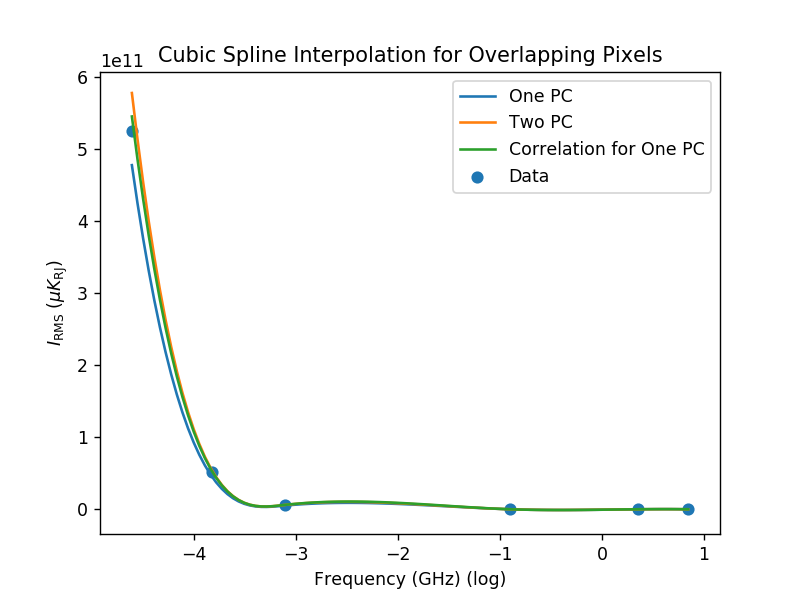

<IPython.core.display.Javascript object>


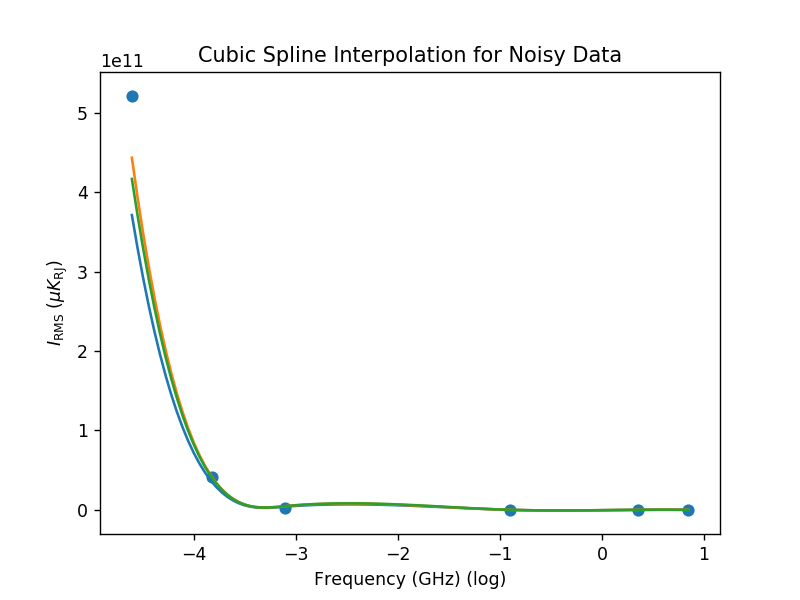

<IPython.core.display.Javascript object>


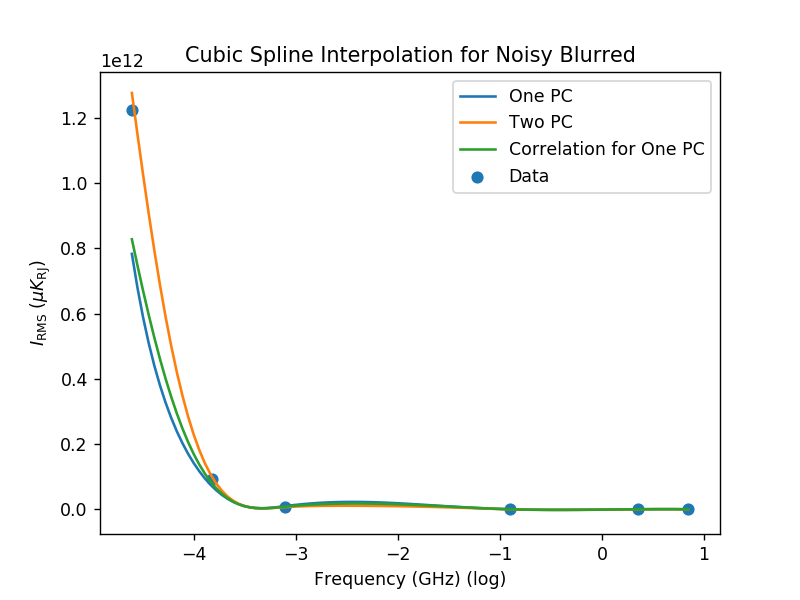

<IPython.core.display.Javascript object>


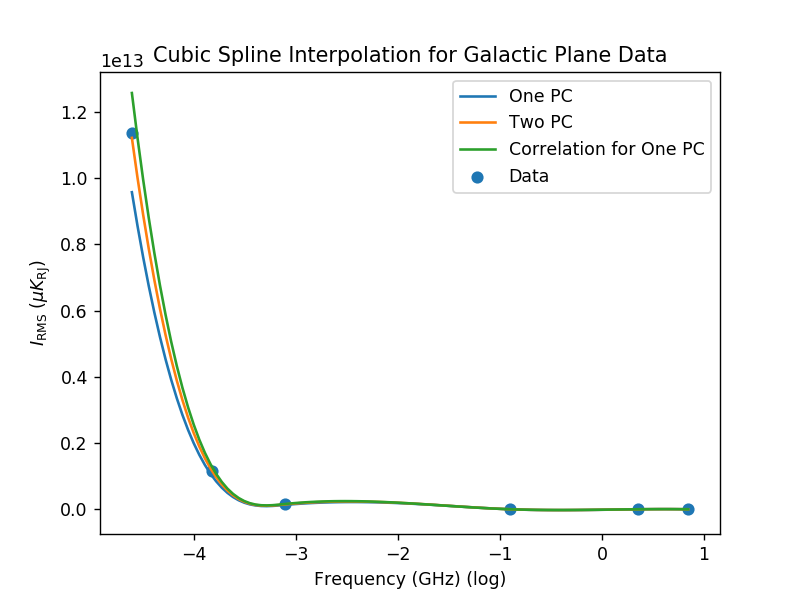

<IPython.core.display.Javascript object>


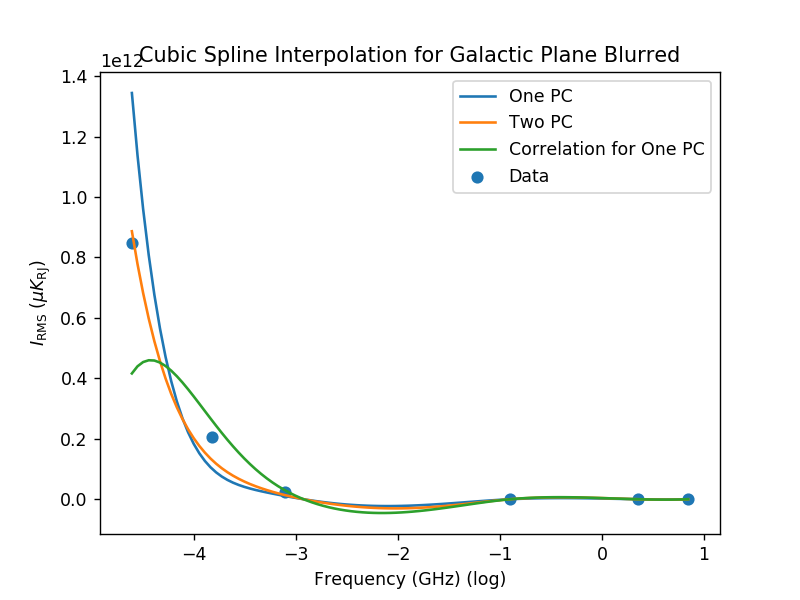

<IPython.core.display.Javascript object>


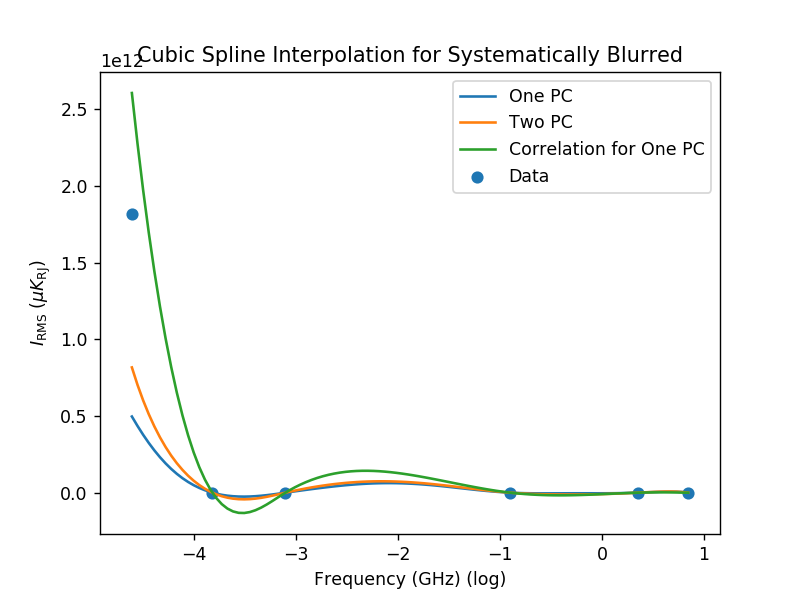

In [13]:
plt.figure()
plt.plot(xnew_uniform_log,newfit[pixel],label='One PC')
plt.plot(xnew_uniform_log,newfit2[pixel],label='Two PC')
plt.plot(xnew_uniform_log,newfit_corr[pixel],label='Correlation for One PC')
plt.scatter(freq_log,clean_matrix[pixel],label='Data')
plt.xlabel('Frequency (GHz) (log)')
plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
plt.title('Cubic Spline Interpolation for Overlapping Pixels')
plt.legend(loc='upper right')
# plt.savefig('clean_fit')

plt.figure()
plt.plot(xnew_uniform_log,newfit_noisy[pixel],label='One PC')
plt.plot(xnew_uniform_log,newfit_noisy2[pixel],label='Two PC')
plt.plot(xnew_uniform_log,newfit_noisycorr[pixel],label='Correlation for One PC')
plt.scatter(freq_log,noisy_matrix[pixel],label='Data')
plt.xlabel('Frequency (GHz) (log)')
plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
plt.title('Cubic Spline Interpolation for Noisy Data')
# plt.legend(loc='upper right')

plt.figure()
plt.plot(xnew_uniform_log,newfit_noisblur[pixel],label='One PC')
plt.plot(xnew_uniform_log,newfit_noisblur2[pixel],label='Two PC')
plt.plot(xnew_uniform_log,newfit_noisblurcorr[pixel],label='Correlation for One PC')
plt.scatter(freq_log,noisblur_matrix[pixel],label='Data')
plt.xlabel('Frequency (GHz) (log)')
plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
plt.title('Cubic Spline Interpolation for Noisy Blurred')
plt.legend(loc='upper right')
# plt.savefig('noisblur_fit')

plt.figure()
plt.plot(xnew_uniform_log,newfit_diff[pixel2],label='One PC')
plt.plot(xnew_uniform_log,newfit_diff2[pixel2],label='Two PC')
plt.plot(xnew_uniform_log,newfit_diffcorr[pixel2],label='Correlation for One PC')
plt.scatter(freq_log,diff_matrix[pixel2],label='Data')
plt.xlabel('Frequency (GHz) (log)')
plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
plt.title('Cubic Spline Interpolation for Galactic Plane Data')
plt.legend(loc='upper right')

plt.figure()
plt.plot(xnew_uniform_log,newfit_diffblur[pixel2],label='One PC')
plt.plot(xnew_uniform_log,newfit_diffblur2[pixel2],label='Two PC')
plt.plot(xnew_uniform_log,newfit_diffblurcorr[pixel2],label='Correlation for One PC')
plt.scatter(freq_log,diffblur_matrix[pixel2],label='Data')
plt.xlabel('Frequency (GHz) (log)')
plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
plt.title('Cubic Spline Interpolation for Galactic Plane Blurred')
plt.legend(loc='upper right')

plt.figure()
plt.plot(xnew_uniform_log,newfit_sysblur[pixel2],label='One PC')
plt.plot(xnew_uniform_log,newfit_sysblur2[pixel2],label='Two PC')
plt.plot(xnew_uniform_log,newfit_sysblurcorr[pixel2],label='Correlation for One PC')
plt.scatter(freq_log,sysblur_matrix[pixel2],label='Data')
plt.xlabel('Frequency (GHz) (log)')
plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)")
plt.title('Cubic Spline Interpolation for Systematically Blurred')
plt.legend(loc='upper right')

## Comparing Power Slope from Clean Data and Blurred Data

In [15]:
clean_pow_slope = np.zeros(clean_matrix.shape[0]) #array of power slopes for clean data
blur_pow_slope = np.zeros(blur_matrix.shape[0]) #array of power slopes for smooth data

# for i in np.arange(clean_matrix.shape[0]):
#     log_clean = (np.log(clean_matrix[i])).reshape(clean_matrix.shape[1],1) #taking log of row of matrix
#     p,param,er = ls.ymodel(freq_pow,log_clean)
#     clean_pow_slope[i] = param[1] 
# # smooth_matrix
# for i in np.arange(blur_matrix.shape[0]):
#     log_blur = (np.log(blur_matrix[i])).reshape(blur_matrix.shape[1],1)
#     p,param,er = ls.ymodel(freq_pow,log_blur)
#     blur_pow_slope[i] = param[1]

In [16]:
print(clean_pow_slope)
print('\n',blur_pow_slope)

[0. 0. 0. ... 0. 0. 0.]

 [0. 0. 0. ... 0. 0. 0.]


## Plotting Spectra

In [17]:
# %%time

# plt.figure()
# plt.plot(list(clean_dict.keys()),list(clean_dict.values()))
# plt.plot(freq,fit_y,linewidth = 3, color = 'black')
# plt.yscale('log')
# plt.xlabel('Frequency')
# plt.ylabel('Intensity')
# plt.title('Spectra')
# plt.show()

In [18]:
# %%time

# plt.figure()
# plt.plot(list(noisy_dict.keys()),list(noisy_dict.values()))
# plt.yscale('log')
# plt.title('Noisy')
# plt.show()